FileUpload(value=(), accept='image/jpeg,image/png', description='Upload')

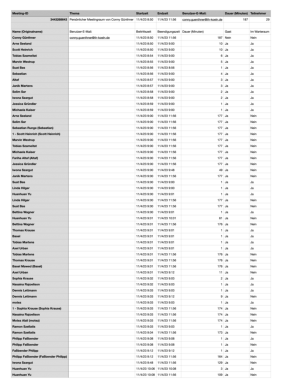

,0,1,2,3,4,5
0,Meeting-ID,Thema Benutzer-E-Mail:,Startzeit,Endzeit,Dauer,(Minuten) Teilnehmer
1,NaN,3443268643 | Persönlicher Meetingraum von ...,Günthner 11/4/23 8:50,11/4/23 11:56,NaN,187
2,Name (Originalname),Benutzer-E-Mail: Dauer (Minuten),Beitrittszeit,Beendigungszeit,Gast,Im Warteraum
3,Conny Günthner,conny.guenthner@th-koeln.de,11/4/23 8:50,11/4/23 11:56,187 Nein,Nein
4,Arne Seeland,NaN,11/4/23 8:50,11/4/23 9:00,10 Ja,Ja
5,Scott Heinrich,NaN,11/4/23 8:50,11/4/23 9:00,10 Ja,Ja
6,Tobias $Szameitat,NaN,11/4/23 8:54,11/4/23 9:00,6 Ja,Ja
7,Marvin Westrup,NaN,11/4/23 8:55,11/4/23 9:00,5 Ja,Ja
8,Suat Bas,NaN,11/4/23 8:56,11/4/23 8:56,1 Ja,Ja
9,Sebastian,NaN,11/4/23 8:56,11/4/23 9:00,4 Ja,Ja


In [1]:
from pathlib import Path
import cv2
import fitz
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pytesseract
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from pytesseract import Output
from concurrent.futures import ThreadPoolExecutor
import time

def preprocess_image_for_ocr(image):
    
    assert image is not None, "file could not be read, check with os.path.exists()"
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #gray = cv2.bilateralFilter(gray, 9, 75, 75)
    
    _,binary = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return binary

def reconstruct_table(ocr_df, row_eps=15, col_eps=70, merge_gap=120):

    def merge_close_clusters(cluster_means, merge_threshold):
        sorted_clusters = sorted(cluster_means.items(), key=lambda x: x[1])
        new_mapping = {}
        current_index = 0
        current_mean = None

        for label, mean in sorted_clusters:
            if current_mean is None:
                current_mean = mean
                new_mapping[label] = current_index
            else:
                if mean - current_mean < merge_threshold:
                    new_mapping[label] = current_index
                    current_mean = (current_mean + mean) / 2.0
                else:
                    current_index += 1
                    current_mean = mean
                    new_mapping[label] = current_index
        return new_mapping

    df = ocr_df.copy()
    df['center_x'] = np.round((df['left'] + (df['left']+df['width']))/2) 
    df['center_y'] = np.round((df['top']+(df['top'] + df['height']))/2) 

    # --- Cluster Zeilen ---
    row_clusterer = DBSCAN(eps=row_eps, min_samples=5)
    df['row_cluster'] = row_clusterer.fit_predict(df[['center_y']].values)
    row_means = df.groupby('row_cluster')['center_y'].mean().sort_values()
    row_map = {old: new for new, old in enumerate(row_means.index)}
    df['row'] = df['row_cluster'].map(row_map)

    # --- Cluster Spalten ---
    col_clusterer = DBSCAN(eps=col_eps, min_samples=15)
    df['col_cluster'] = col_clusterer.fit_predict(df[['center_x']].values)
    col_means = df.groupby('col_cluster')['center_x'].mean().to_dict()
    new_col_map = merge_close_clusters(col_means, merge_threshold=merge_gap)
    df['col'] = df['col_cluster'].map(new_col_map)
    
    # --- Tabelle erstellen ---
    table_dict = {}
    for _, row in df.iterrows():
        r = int(row['row'])
        c = int(row['col'])
        txt = str(row['text']).strip() if pd.notnull(row['text']) else ""
        if (r, c) in table_dict:
            table_dict[(r, c)] += " " + txt
        else:
            table_dict[(r, c)] = txt

    num_rows = df['row'].max()+1
    num_cols = df['col'].max()+1
    
    table = []
    for r in range(num_rows):
        row_data = []
        for c in range(num_cols):
            cell_text = table_dict.get((r, c), "")
            row_data.append(cell_text)
        table.append(row_data)
    
    return pd.DataFrame(table)


def process_image_to_table(img, language='deu', config='--psm 6'):
    start_time = time.time()
    img = preprocess_image_for_ocr(img)
    df = pytesseract.image_to_data(img, output_type=Output.DATAFRAME, lang=language)
    table_df = reconstruct_table(df).dropna()
    table_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    table_df.dropna(how="all", inplace=True)
    print(f"Total processing time: {time.time() - start_time:.2f} seconds")
    return img, df, table_df


import ipywidgets as widgets
import cv2
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

uploaded_file_content = None
uploaded_filename = None

def read_and_process_image():
    global uploaded_file_content, uploaded_filename
    
    if uploaded_file_content is not None:
        img_array = np.asarray(bytearray(uploaded_file_content), dtype=np.uint8)
        
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR) 
        
        if img is not None:
            print(f"Processing image: {uploaded_filename}")
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            plt.imshow(gray_img, cmap='gray')
            plt.axis('off')
            plt.show()
            _, _, table_df = process_image_to_table(img)
            display(table_df)
        else:
            print("Failed to load image.")
    else:
        print("No image uploaded yet.")

def handle_upload(change):
    global uploaded_file_content, uploaded_filename
    uploaded_file = change['new']
    
    if uploaded_file:
        file_info = uploaded_file[0]
        uploaded_file_content = uploaded_file[0].content
        uploaded_filename = file_info['name']
        
        display(HTML(f"<h5>Filename: {uploaded_filename}</h5>"))
        read_and_process_image()
        print(f"File {uploaded_filename} has been successfully uploaded and stored in memory!")

file_picker = widgets.FileUpload(accept='image/jpeg,image/png', multiple=False)

# Callback für die Datei Selektion  
file_picker.observe(handle_upload, names='value')

display(file_picker)